``` python
# if you running at azure nootbook to prepare env
#!pip install lxml --ignore-installed lxml
#!pip install tushare==1.2.54 
```

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from greenseer.configuration import do_global_configuration
from greenseer.dataset.china_dataset import fetch_default_targets, stock_info, TRAIN_SET_ALL, fetch_train_set
from greenseer.dataset.china_dataset import fetch_multi_report
from logging.config import fileConfig
import numpy as np
from sklearn.pipeline import Pipeline
from greenseer.preprocessing.transformers import regular_expression_column_filter, \
    pick_annual_report_china, append_industry_transform, re_sum_column_transform, re_percent_column_transform, \
    remove_inf_and_na
%matplotlib inline
import matplotlib.pyplot as plt
do_global_configuration("config.properties")
fileConfig('logging_config.ini')

- 600519：茅台

In [72]:
# reports = fetch_multi_report(stock_ids=np.array(["600519","600520"]))
reports = fetch_train_set(TRAIN_SET_ALL)

In [73]:
subjects = [r'\w*应付\w*|\w*应收\w*|存货|货币资金|\w*生物\w*|\w*资产总计\w*']


prepare_pipeline = Pipeline([
        ('pick_annual_report', pick_annual_report_china()),
        ('pick_subject', regular_expression_column_filter(patterns=subjects,rename={"资产总计(万元)":"base"})),
        ('percent payable', re_percent_column_transform(numerator=[r'\w*应付\w*'], denominator=[r'base'],new_name='payable')),
        ('percent receivable', re_percent_column_transform(numerator=[r'\w*应收\w*'], denominator=[r'base'],new_name='receivable')),
        ('append industry',append_industry_transform()),
        ('clean data',remove_inf_and_na())
])

data = prepare_pipeline.fit_transform(reports)

In [74]:
summary_by_category = data[['industry','receivable','payable',"base"]].groupby("industry")
mean= summary_by_category.mean()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc172d1cf90>,
      dtype=object)

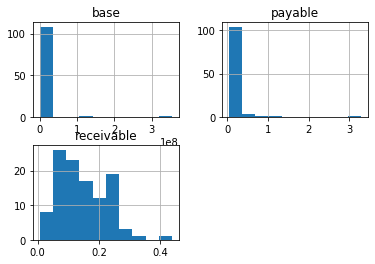

In [75]:
mean.hist()

